<a href="https://colab.research.google.com/github/alinorouziani/FoodClassificationCustomDataTinyVGG/blob/main/FoodClassificationCustomDataTinyVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The device is on: {device}")

The device is on: cuda


In [2]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists.")
else:
    print(f"Creating {image_path} directory...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading the data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip:
  print("Unzipping the file...")
  zip.extractall(image_path)

Creating data/pizza_steak_sushi directory...
Unzipping the file...


In [3]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are{len(dirnames)} diretories and {len(filenames)} image in {dirpath}.")

walk_through_dir(image_path)

There are2 diretories and 0 image in data/pizza_steak_sushi.
There are3 diretories and 0 image in data/pizza_steak_sushi/test.
There are0 diretories and 19 image in data/pizza_steak_sushi/test/steak.
There are0 diretories and 25 image in data/pizza_steak_sushi/test/pizza.
There are0 diretories and 31 image in data/pizza_steak_sushi/test/sushi.
There are3 diretories and 0 image in data/pizza_steak_sushi/train.
There are0 diretories and 75 image in data/pizza_steak_sushi/train/steak.
There are0 diretories and 78 image in data/pizza_steak_sushi/train/pizza.
There are0 diretories and 72 image in data/pizza_steak_sushi/train/sushi.


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=train_dir, transform=transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=transform, target_transform=None)
class_names = train_data.classes

train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, num_workers=os.cpu_count(), shuffle=False)

In [6]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


In [7]:
from torch import nn
class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
    )
  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [8]:
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

In [10]:
from tqdm.auto import tqdm

def train_step(model, dataloader, loss_fn, optimizer, device):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
  results = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
epochs = 20
results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.0036 | Train acc: 1.0000 | Test loss: 7.6139 | Test acc: 0.4533
Epoch: 2 | Train loss: 0.0546 | Train acc: 0.9867 | Test loss: 9.1333 | Test acc: 0.4800
Epoch: 3 | Train loss: 0.0202 | Train acc: 0.9911 | Test loss: 6.5208 | Test acc: 0.5467
Epoch: 4 | Train loss: 0.1034 | Train acc: 0.9778 | Test loss: 6.0790 | Test acc: 0.5467
Epoch: 5 | Train loss: 0.2119 | Train acc: 0.9556 | Test loss: 5.9877 | Test acc: 0.4933
Epoch: 6 | Train loss: 0.0237 | Train acc: 0.9911 | Test loss: 5.1874 | Test acc: 0.5067
Epoch: 7 | Train loss: 0.0501 | Train acc: 0.9822 | Test loss: 5.2951 | Test acc: 0.5067
Epoch: 8 | Train loss: 0.0058 | Train acc: 1.0000 | Test loss: 4.3586 | Test acc: 0.5333
Epoch: 9 | Train loss: 0.0014 | Train acc: 1.0000 | Test loss: 4.8921 | Test acc: 0.5733
Epoch: 10 | Train loss: 0.0023 | Train acc: 1.0000 | Test loss: 5.0370 | Test acc: 0.4933
Epoch: 11 | Train loss: 0.0010 | Train acc: 1.0000 | Test loss: 5.0130 | Test acc: 0.5467
Epoch: 12 | Train l

**Now you can upload a picture and let the model predict what it is:**

In [21]:
import torchvision
img = torchvision.io.read_image("/content/steak.jpg")
img

tensor([[[239, 239, 239,  ..., 249, 249, 249],
         [239, 239, 239,  ..., 249, 249, 249],
         [239, 239, 239,  ..., 249, 249, 249],
         ...,
         [159, 158, 157,  ..., 213, 213, 214],
         [171, 170, 169,  ..., 209, 209, 209],
         [180, 179, 176,  ..., 206, 206, 206]],

        [[240, 240, 240,  ..., 218, 218, 218],
         [240, 240, 240,  ..., 218, 218, 218],
         [240, 240, 240,  ..., 219, 219, 219],
         ...,
         [111, 110, 109,  ..., 158, 158, 159],
         [123, 122, 121,  ..., 154, 154, 154],
         [132, 131, 128,  ..., 151, 151, 151]],

        [[234, 234, 234,  ..., 213, 213, 213],
         [234, 234, 234,  ..., 213, 213, 213],
         [234, 234, 234,  ..., 211, 211, 211],
         ...,
         [ 89,  88,  87,  ..., 138, 138, 139],
         [101, 100,  99,  ..., 134, 134, 134],
         [110, 109, 106,  ..., 131, 131, 131]]], dtype=torch.uint8)

(-0.5, 63.5, 63.5, -0.5)

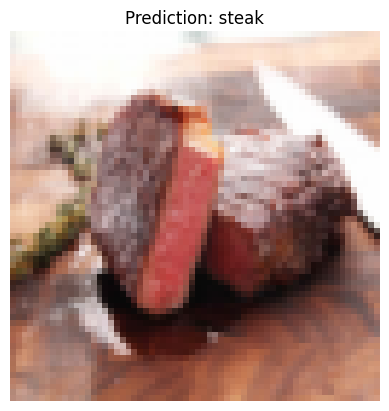

In [22]:
import matplotlib.pyplot as plt
model.eval()
with torch.inference_mode():
  img = img.type(torch.float32) / 255.0
  resize = transforms.Resize((64,64))
  img = resize(img)
  batch = img.unsqueeze(0).to(device)
  y_pred_logits = model(batch)
  pred_label = torch.argmax(y_pred_logits, dim=1)

plt.imshow(img.permute(1,2,0))
plt.title(f"Prediction: {class_names[pred_label]}")
plt.axis(False)